# (some) Related Work

# Abstract

# Intro to Numba
In the next section we will be needing some speed to run some tests. Python isn't known for speed. We will for now use numba to speed up Python because it requires basically the no amount of effort (for simple code) if you already know Python just some details you have to know. 

## What is Numba
Go see https://numba.pydata.org/. <br>
Numba translates Python functions to optimized machine code at runtime using the industry-standard LLVM compiler library. Numba-compiled numerical algorithms in Python can approach the speeds of C or FORTRAN.

You don't need to replace the Python interpreter, run a separate compilation step, or even have a C/C++ compiler installed. Just apply one of the Numba decorators to your Python function, and Numba does the rest. <br>

## Installation
We installed numba via anaconda (conda install numba). We think you can also install it with pip if you have the correct version of Python.

## Example
Here is a quick example to get your feet wet:

In [45]:
from random import random
from numba import njit, prange

# normal way:
def Y(t): return 1 + (Y(random()*t) if random()<t else 0)
def y(t,nsim): return sum(Y(t) for _ in range(nsim))/nsim

# numba way:
@njit(fastmath=True)
def Yn(t): return 1.0 + (Yn(random()*t) if random()<t else 0.0)

@njit(fastmath=True, parallel=True)
def yn(t, nsim):
    total = 0.0 # <- typing becomes important 0 vs 0.0
    for _ in prange(nsim):
        total += Yn(t)
    return total/nsim

In [49]:
t,nsim = 1,10**5
%timeit y(t,nsim)
%timeit yn(t,nsim)

215 ms ± 89.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.77 ms ± 295 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In this example numba speeded up the running time 40 times (on our laptop) with minor changes (typing, decorators, parallel). 

## Disadvantages
Here are some of the main drawbacks of using Numba:

-   Limited support for Python features: Numba supports a limited subset of Python features, which means that not all Python code can be accelerated with Numba.

-   Compilation time: Numba needs to compile the code before it can execute it, which can take some time. This overhead can be significant for small computations, making it less efficient than native Python.

-   Memory usage: Numba can increase the memory usage of Python programs, which can be a problem for large-scale computations.

-   Debugging: Numba can make debugging more difficult, as the compiled code is not as easy to read and understand as native Python code.



# Half Variance Phenomenon
Ok we need a better name for this. The half variance phenomenon is the order improvement of turning classic deterministic integrators into Monte Carlo ones. The order improvement happens because of instead summing errors you sum variances which after taking the $\sqrt{ }$ end up reducing the order less.

## MC Trapezium Rule
To demonstrate the half variance phenomenon we compare the classic trapezium rule with the MC trapezium rule. In $1$ dimensional integration we get a free half order of convergence, in $d$ dimensional this becomes $\frac{d}{2}$ (we only test this in $2$ dimensions).

In [352]:
from random import random
from math import exp
from numba import njit, prange
from functools import lru_cache
import numpy as np
import matplotlib.pyplot as plt


#@lru_cache(maxsize=4)
@njit
def f(x): return exp(x)

@njit(fastmath=True)
def trapezium(n,a,b):
    dx = (b-a)/n
    x,sol = 0,0
    for _ in range(n):
        xx = x + dx
        sol += (f(x)+f(xx))/2 # inefficient
        x = xx
    return sol*dx

@njit(fastmath=True)
def MCtrapezium(n,a,b):
    dx = (b-a)/n
    x,sol = 0,0
    for _ in range(n):
        xx = x + dx
        sol += (f(x)+f(xx))/2 # inefficient
        l = 20 # russian roulette rate l**2 influence on variance
        if random()*l<1:
            U = x + random()*(xx-x) # \sim Uniform(x,xx)
            sol += l*(f(U)-f(x)-(U-x)*(f(xx)-f(x))/dx)
        x = xx
    return sol*dx

def exact(a,b): return exp(b)-exp(a) 



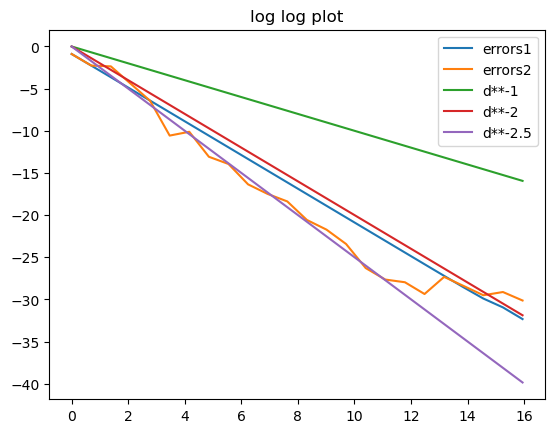

In [353]:
n,a,b = 100,0,1

DTS = np.power(2,np.array(range(24)))
errors1 = np.array([(abs(trapezium(n,a,b)-exact(a,b)))/(exact(a,b)) for n in DTS])
errors2 = np.array([(abs(MCtrapezium(n,a,b)-exact(a,b)))/(exact(a,b)) for n in DTS])
ref = np.array([1/d for d in DTS])
ref2 = np.array([pow(1/d,2) for d in DTS])
ref3 = np.array([pow(1/d,2.5) for d in DTS])

plt.plot(np.log(DTS),np.log(errors1*5), label = "errors1")
plt.plot(np.log(DTS),np.log(errors2*5), label = "errors2")
plt.plot(np.log(DTS),np.log(ref),label ='d**-1')
plt.plot(np.log(DTS),np.log(ref2), label="d**-2")
plt.plot(np.log(DTS),np.log(ref3), label="d**-2.5")
plt.legend()
plt.title("log log plot")
plt.show()


we don't know what goes wrong in the convergence probably numerical precision stuff ... 

In [25]:
from random import random
from math import exp
from numba import njit, prange
from functools import lru_cache
import numpy as np
import matplotlib.pyplot as plt


#@lru_cache(maxsize=4)
@njit
def f(x,y): return exp(x)*exp(y)

@njit(fastmath=True)
def trapezium2(n):
    d = 1/n
    x,sol = 0,0
    for _ in range(n):
        y = 0
        for _ in range(n):
            sol += ((f(x+d,y)+f(x,y+d))/2 )*d**2 # inefficient
            y +=d
        x+=d
    return sol


@njit(fastmath=True)
def MCtrapezium2(n):
    d = 1/n
    x,sol = 0,0
    for _ in range(n):
        y = 0
        for _ in range(n):
            sol += ((f(x+d,y)+f(x,y+d))/2 )*d**2 # inefficient
            l = 5
            if random()*l<1:
                X = x+ d*random()
                Y = y+ d*random()
                sol += l*(f(X,Y)-(f(x,y)+(f(x+d,y)-f(x,y))*(X-x)/d+(f(x,y+d)-f(x,y))*(Y-y)/d))*d**2 
            y +=d
        x+=d
    return sol

def exact2(): return (exp(1)-1)**2



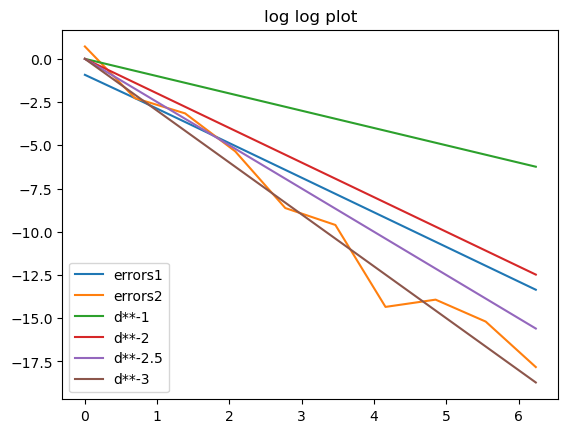

In [26]:
DTS = np.power(2,np.array(range(10)))

errors1 = np.array([(abs(trapezium2(n)-exact2()))/(exact2()) for n in DTS])
errors2 = np.array([(abs(MCtrapezium2(n)-exact2()))/(exact2()) for n in DTS])
ref = np.array([1/d for d in DTS])
ref2 = np.array([pow(1/d,2) for d in DTS])
ref3 = np.array([pow(1/d,2.5) for d in DTS])
ref4 = np.array([pow(1/d,3) for d in DTS])

plt.plot(np.log(DTS),np.log(errors1*5), label = "errors1")
plt.plot(np.log(DTS),np.log(errors2*5), label = "errors2")
plt.plot(np.log(DTS),np.log(ref),label ='d**-1')
plt.plot(np.log(DTS),np.log(ref2), label="d**-2")
plt.plot(np.log(DTS),np.log(ref3), label="d**-2.5")
plt.plot(np.log(DTS),np.log(ref4), label="d**-3")
plt.legend()
plt.title("log log plot")
plt.show()
